In [3]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
import time


In [41]:
# Simulation Parameters
length = 10 # Meters
resolution = 1000

# Firefly Parameters
vision_length = 3 #meters
vision_cone = 40 #degrees

In [62]:
"""  MOST LIKELY SCRAPPING
class firefly:
    def __init__(self, x, y, z, pitch, yaw):
        self.pos = (x,y,z)
        self.direction = (pitch, yaw)

    def update_pos(self, center_mass):
        # Biased correlated random walk
        # Update the position (spatial) and direction (orientation) for next iteration
        self.pos = None
        self.direction = None

    def identify_vision(self):
        # Identify which other fireflies are in vision
        return(None)
"""


class swarm:
    def __init__(self, n, spread, attraction, repulsion, randomness, sim_frames = 100):
        self.fireflies = []
        self.N = n
        self.c1 = attraction  # Attraction Scaling factor
        self.c2 = repulsion  # Repulsion scaling factor
        self.c3 = randomness  # Randomness scaling factor

        self.frames = sim_frames  # No. of frames
        self.pspread = spread  # Spread of initial positions (gaussian)
        self.vspread = 2  # Spread of initial velocitys (gaussian)

        # initiaized below
        self.p = None
        self.v = None
        self.o = None

    def initialize(self):
        # positions
        self.p = np.random.normal(loc=10, scale=self.pspread, size=(3, self.N))
        # velocities
        self.v = self.vspread*np.random.randn(3, self.N)
        self.v = self.v / np.linalg.norm(self.v, axis=0)
        #self.fig = plt.figure()
        #self.ax = self.fig.add_subplot(111)

    def __repr__(self):
        return self.p
    
    def graph(self, time = False):
        x = self.p[0,:]
        y = self.p[1,:]
        z = self.p[2,:]

        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
    
        # Creating plot
        ax.scatter3D(x,y,z, color = "green")
        if time == True:
            plt.title("Fireflies in Space"+str())
        else:
            plt.title("Fireflies in Space")

        ax.set_xlim3d(0,20)
        ax.set_ylim3d(0,20)
        ax.set_zlim3d(0,20)
    


    def ff_in_vision(self, n):
        ## KURT ##
        ## For now, develop this method that will return the indexes of fireflies
        ## in the visual range of firefly index n. i.e. self.p[:,n]
        ## you'll need to determine the orientation of the firefliy with the
        ## 3D velocity vectors in self.v[:,n], and then extend out a 3D cone
        ## with some arbitrary parameters (I'm thinking h = 1m, r = .3m?)
        ## reuturn all indicies for fireflies that fall within that cone
        ## try to make it computationally efficient.
        return None

    def center_mass(self):  # Calculate center of gravity of all fireflies
        pos_sums = 0
        for i in range(self.N):
            pos_sums += self.p[:,i]
        return(pos_sums / self.N)
    
    def simulate(self):
        # Simulate firefly swarm
        center = self.center_mass()
        print(center)
        for _ in range(self.frames):
            for _ in range(self.N):
                pass

        
        # Further calculations below:
    
    


In [79]:
t = 3*np.random.randn(3, 5)
print(t)
t / np.linalg.norm(t, axis=0)

[[ 0.94020319  0.50131862 -4.80036653 -5.35669294 -4.18404094]
 [-1.04663166 -0.39276183  0.79408708 -1.16485214 -2.49931355]
 [-1.7839038   0.33185824  2.20595497  1.20341962 -0.59946546]]


array([[ 0.4138319 ,  0.698088  , -0.89855549, -0.9544355 , -0.85207569],
       [-0.46067656, -0.54692227,  0.148641  , -0.207549  , -0.50898267],
       [-0.78518804,  0.4621138 ,  0.41292117,  0.2144208 , -0.12208053]])

[10.82456077  9.20648413 10.65173178]


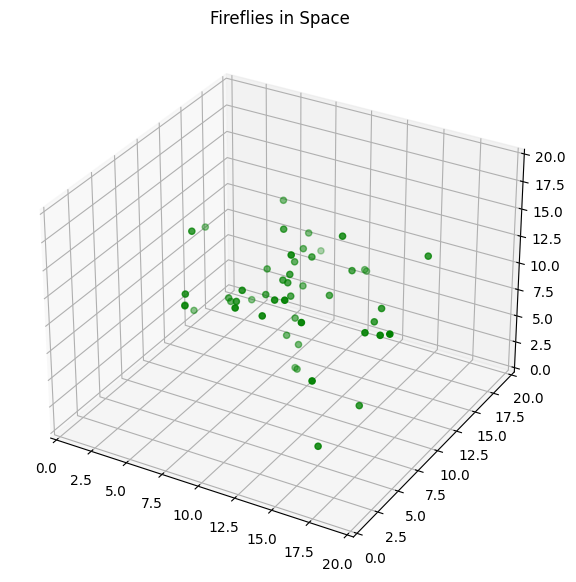

In [74]:
n_agents = 50
c1 = 0.00001  # attraction
c2 = 0.01  # repulsion
c3 = 0.01  # randomness
c4 = 3.5

fireflies = swarm(n = n_agents, spread = c4, attraction = c1, repulsion = c2, randomness = c3)
fireflies.initialize()
fireflies.simulate()
fireflies.graph()